# 프로젝트: 한영 번역기 만들기

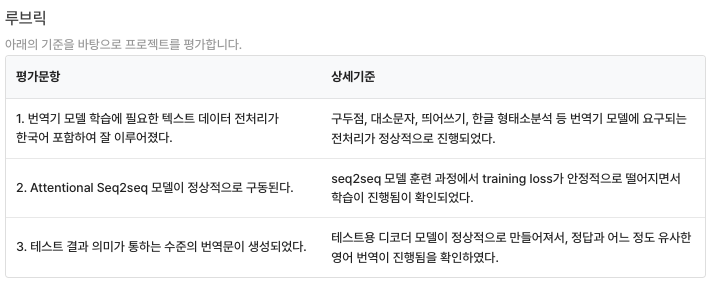

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

# 데이터 준비하기

import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

print(tf.__version__)

2.6.0


In [2]:
import pandas
import tensorflow
import matplotlib

print(pandas.__version__)
print(tensorflow.__version__)
print(matplotlib.__version__)

1.3.3
2.6.0
3.4.3


## Step 1. 데이터 다운로드

In [3]:
path_to_zip = tf.keras.utils.get_file(
    'korean-english-park.train.tar',
    origin = 'https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz',
    extract=True,
    archive_format='tar') # format 'tar' can also unzip tar.gz file

eng_path_to_file = os.path.dirname(path_to_zip) + '/korean-english-park.train.en'
kor_path_to_file = os.path.dirname(path_to_zip) + '/korean-english-park.train.ko'

8732672/8718893 [==============================] - 0s 0us/step


In [4]:
with open(kor_path_to_file, "r") as f:
    ko_raw = f.read().splitlines()

print("Data Size:", len(ko_raw))
print("Example:")

for sen in ko_raw[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


In [5]:
with open(eng_path_to_file, "r") as f:
    eng_raw = f.read().splitlines() # line 별로 split

print("Data Size:", len(eng_raw))
print("Example:")

for sen in eng_raw[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they get from aerobic activities such as brisk walking or running for at least 20 minutes.


## Step 2. 데이터 정제

In [6]:
cleaned_corpus = [] # concatenate both corpus into one

for i in range(len(eng_raw)) :
    cleaned_corpus.append(eng_raw[i] +'\t'+ ko_raw[i]) # eng + \t + kor

In [7]:
#세트로 중복 제거
cleaned_corpus = set(cleaned_corpus)

In [8]:
# 데이터 전처리: 정제하기

from konlpy.tag import Mecab
mecab = Mecab()

def preprocess_sentence(sentence, s_token=False, e_token=False, kor=False):
    if kor :
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
        sentence = re.sub(r'[" "]+', " ", sentence) 
        sentence = re.sub(r"[^ㄱ-ㅎ가-힣?.!,]+", " ", sentence)
        mecab = Mecab()
        sentence = mecab.morphs(sentence)
        sentence = ' '.join(sentence)

    else :
        sentence = sentence.lower().strip()
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
        sentence = re.sub(r'[" "]+', " ", sentence)
        sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)

        sentence = sentence.strip()

        if s_token:
            sentence = '<start> ' + sentence

        if e_token:
            sentence += ' <end>'
            
#         sentence = sentence.split()
    
    return sentence

print("슝~")

슝~


In [9]:
enc_corpus = []
dec_corpus = []
num_examples = 30000

for sentence in list(cleaned_corpus)[: num_examples]:
    eng, kor = sentence.split('\t')
    
    kor = preprocess_sentence(kor, kor = True)
    eng = preprocess_sentence(eng, s_token=True, e_token=True)
    
    if len(mecab.morphs(kor)) < 40 and len(eng.split()) < 42 : # token size limit to less than 40, eng 40 + 2 sp tkn
        enc_corpus.append(kor)
        dec_corpus.append(eng)
    
print('Korean: ',enc_corpus[0])  
print('English: ',dec_corpus[0]) 

Korean:  댕기 열 은 일반 적 으로 가지 바이러스 로 인해 감염 된다 .
English:  <start> dengue fever , the more common form of dengue , is caused by four closely related viruses . <end>


In [10]:
def find_maxlen(corpus, kor = False) : 
    '''
    returns the max number of token(seq) and the index corresponding to it
    '''
    max_len = 0
    idx = 0
    
    for i,sen in enumerate(corpus) :
        if kor :
            length = len(mecab.morphs(sen))
            if max_len < length : 
                max_len = length
                idx = i
        else :
            length = len(sen.split())
            if max_len < length : 
                max_len = length
                idx = i
                
    return max_len,idx

In [11]:
print('encoder max_seq:' , find_maxlen(enc_corpus, kor=True))
print('decoder max_seq:' , find_maxlen(dec_corpus))

encoder max_seq: (39, 34)
decoder max_seq: (41, 102)


## Step 3. 데이터 토큰화

In [12]:
enc_corpus[0]

'댕기 열 은 일반 적 으로 가지 바이러스 로 인해 감염 된다 .'

In [13]:
# tokenize function using keras

def tokenize(corpus, kor = False):
    if kor :
        mecab = Mecab()
        sentence = []
        
        for sen in corpus :
            sentence.append(mecab.morphs(sen))
            
        tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = 20000, filters='')
        tokenizer.fit_on_texts(sentence)

        tensor = tokenizer.texts_to_sequences(corpus)

        tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
            
    else :
        tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = 20000, filters='')
        tokenizer.fit_on_texts(corpus)
        
        tensor = tokenizer.texts_to_sequences(corpus)

        tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [14]:
# 토큰화하기
enc_tensor, enc_tokenizer = tokenize(enc_corpus, kor=True)
dec_tensor, dec_tokenizer = tokenize(dec_corpus)

print("Korean Vocab Size:", len(enc_tokenizer.index_word))
print("English Vocab Size:", len(dec_tokenizer.index_word))

Korean Vocab Size: 25086
English Vocab Size: 26088


In [15]:
enc_tensor[0]

array([8782,  531,    7,  851,   35,   19,  353,  949,   21,  339,  852,
        131,    1,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

In [16]:
for i in enc_tensor[0] :
    if i != 0:
        print(enc_tokenizer.index_word[i], end = ' ')

댕기 열 은 일반 적 으로 가지 바이러스 로 인해 감염 된다 . 

In [17]:
for i in dec_tensor[0] :
    if i != 0:
        print(dec_tokenizer.index_word[i], end = ' ')

<start> dengue fever , the more common form of dengue , is caused by four closely related viruses . <end> 

## Step 4. 모델 설계

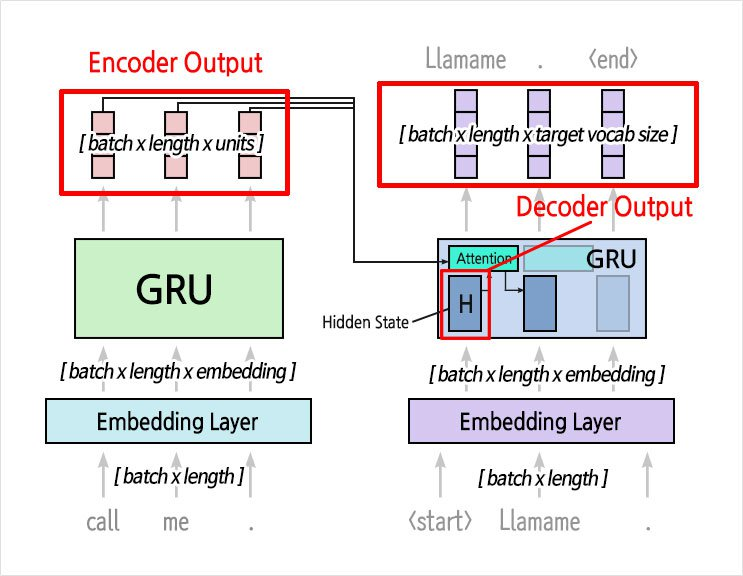

In [18]:
# attenntion 정의

class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

print("슝~")

슝~


In [19]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out

In [20]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.dropout = tf.keras.layers.Dropout(0.5) # addd dropout layer
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = self.dropout(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [25]:
# hyperparameter

BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1 # add 1 for padding 
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1 # add 1 for padding 

units         = 1024 #dimension for gru
embedding_dim = 512 # dimension for embedding

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

## Step 5. 훈련하기

In [26]:
optimizer = tf.keras.optimizers.Adam(0.001)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

print("슝~")

슝~


In [27]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

print("슝~")

슝~


In [28]:
#  훈련하기 (3) 훈련 시작하기
from tqdm import tqdm    # tqdm
import random

EPOCHS = 25

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_tensor.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_tensor[idx:idx+BATCH_SIZE],
                                dec_tensor[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 25: 100%|██████████| 371/371 [03:29<00:00,  1.77it/s, Loss 0.2588]


In [29]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_tensor.shape[-1], enc_tensor.shape[-1]))
    
    sentence = preprocess_sentence(sentence, kor =True) # kor True 
    inputs = enc_tokenizer.texts_to_sequences([sentence])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_tensor.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_tensor.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))


In [30]:
test_corpus = ['오바마는 대통령이다.','시민들은 도시 속에 산다.','커피는 필요 없다.','일곱 명의 사망자가 발생했다.']

Input: 오바마 는 대통령 이 다 .
Predicted translation: obama was passed in the president . <end> 


/tmp/ipykernel_31/4180281196.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_31/4180281196.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


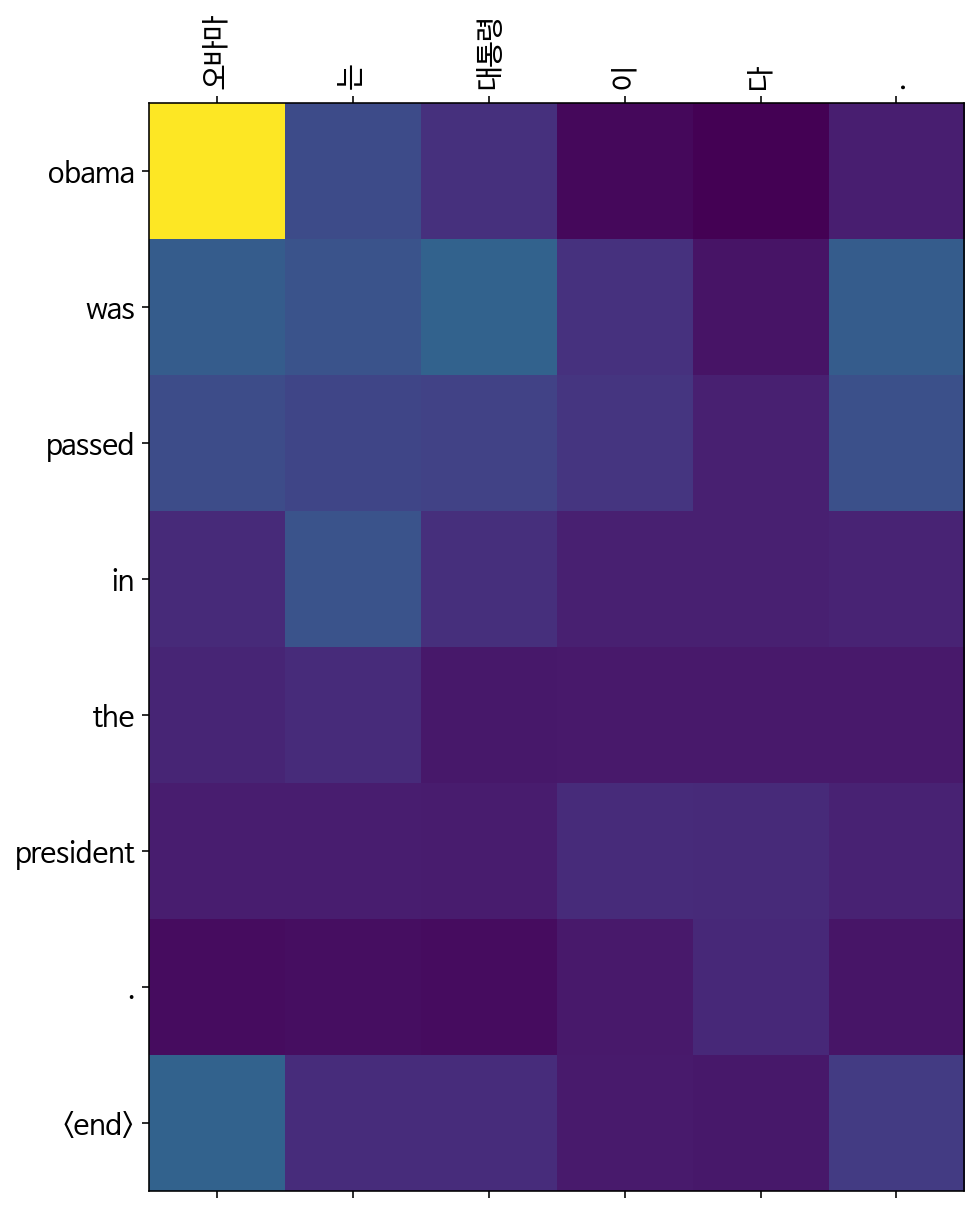

Input: 시민 들 은 도시 속 에 산다 .
Predicted translation: they are homeless . <end> 


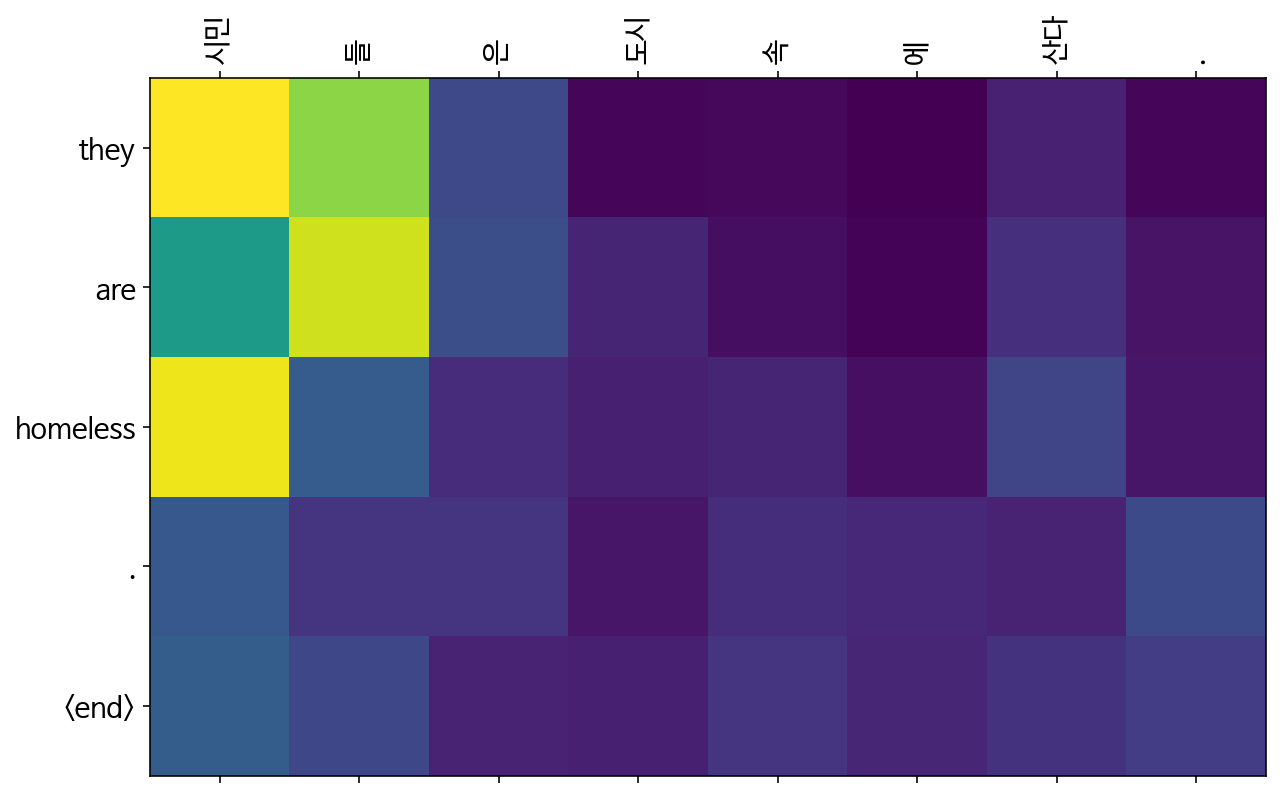

Input: 커피 는 필요 없 다 .
Predicted translation: the one is familiar with a caffeine buzz . <end> 


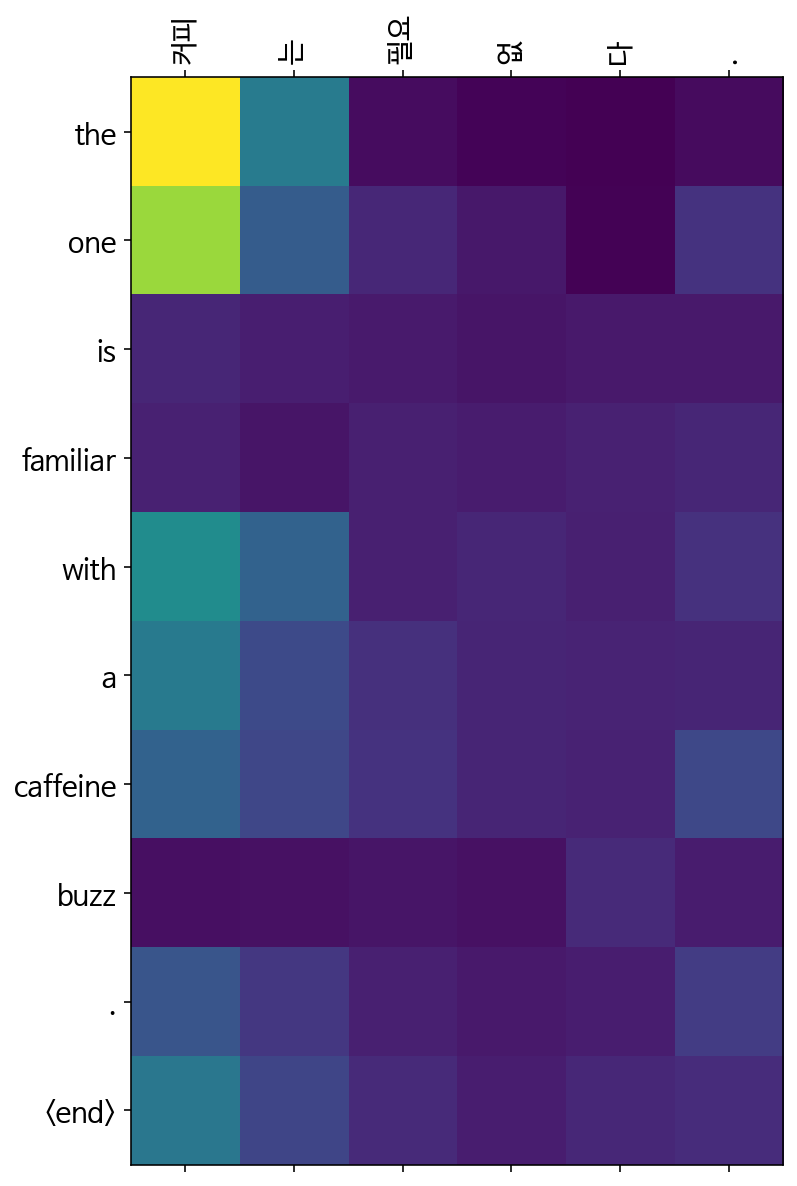

Input: 일곱 명 의 사망자 가 발생 했 다 .
Predicted translation: th . <end> 


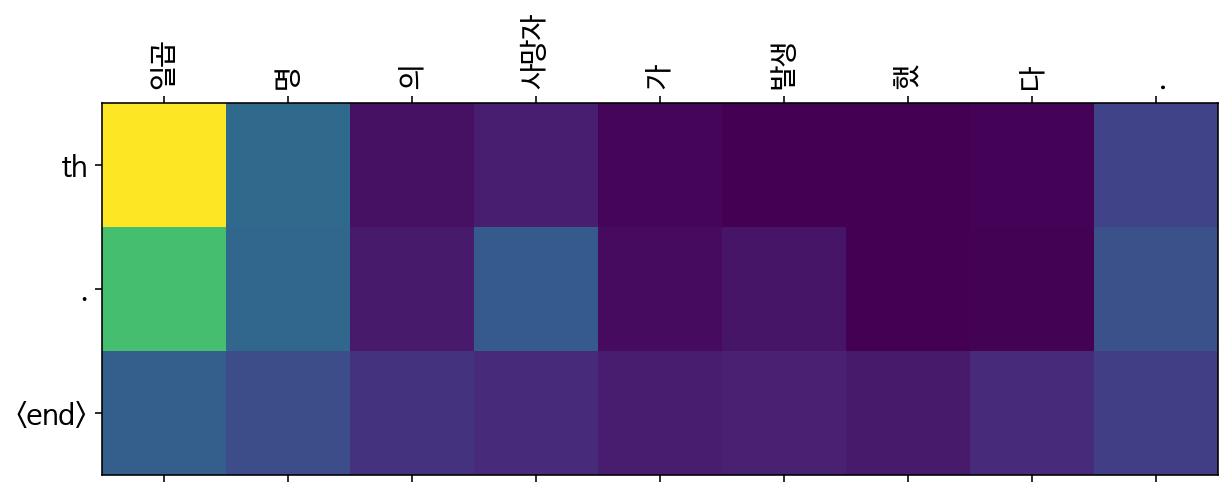

In [32]:
for i in test_corpus :
    translate(i, encoder, decoder) 

음.... 번역이 완벽하지는 않다... 그러나 주요 단어들은 나타나는 것을 볼 수 있습니다.